In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [17]:
import matplotlib.colors as mcolors

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [3]:
from eofs.xarray import Eof

In [4]:
from dask.distributed import Client, progress

In [5]:
client = Client()  # set up local cluster on your laptop
client

2022-10-14 15:43:24,271 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/v0/cpy7g6tj06v67n1n6bf80bpw0000gp/T/dask-worker-space/worker-ipliafpb', purging
2022-10-14 15:43:24,271 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/v0/cpy7g6tj06v67n1n6bf80bpw0000gp/T/dask-worker-space/worker-o4vbme_p', purging
2022-10-14 15:43:24,271 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/v0/cpy7g6tj06v67n1n6bf80bpw0000gp/T/dask-worker-space/worker-c_gmtu0d', purging
2022-10-14 15:43:24,272 - distributed.diskutils - INFO - Found stale lock file and directory '/var/folders/v0/cpy7g6tj06v67n1n6bf80bpw0000gp/T/dask-worker-space/worker-u9oyql6k', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 8,Total memory: 8.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:61439,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 8.00 GiB
Comm: tcp://127.0.0.1:61454,Total threads: 2
Dashboard: http://127.0.0.1:61455/status,Memory: 2.00 GiB
Nanny: tcp://127.0.0.1:61442,


# §1 Load data

## §1.1 Land-sea mask

In [5]:
url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
ds_mask = xr.open_dataset(url)
ds_mask

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 1)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01
Data variables:
    utc_date   (time) int32 ...
    LSM        (time, latitude, longitude) float32 ...
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper04 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon May 13 18:10:35 MDT 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon May 13 18:10:35 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.4 (http://n...
    DODS_EXTRA.Unlimited_Dimension:  time

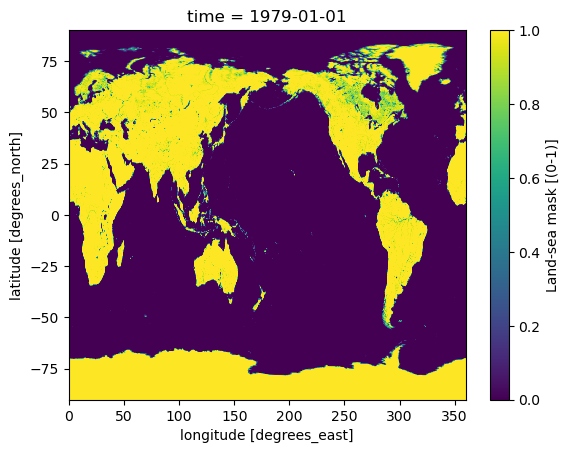

In [6]:
# squeeze the time dimension
lsm = ds_mask['LSM'].squeeze(dim='time')
lsm.plot()

## §1.2 Sea surface temperature

In [7]:
base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/'
base_url2 = '/e5.moda.an.sfc.128_034_sstk.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list_sstk=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list_sstk.append(single_file)

file_list_sstk

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1979/e5.moda.an.sfc.128_034_sstk.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1980/e5.moda.an.sfc.128_034_sstk.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1981/e5.moda.an.sfc.128_034_sstk.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1982/e5.moda.an.sfc.128_034_sstk.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1983/e5.moda.an.sfc.128_034_sstk.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1984/e5.moda.an.sfc.128_034_sstk.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.an.sfc/1985/e5.moda.an.sfc.128_034_sstk.ll025sc.1985010100_1985120100.nc',
 'https://rda.ucar.edu/thre

In [8]:
ds_sstk = xr.open_mfdataset(file_list_sstk, parallel=True)
ds_sstk

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 516)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    SSTK       (time, latitude, longitude) float32 dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 07:46:57 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 07:46:58 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [9]:
sstk = ds_sstk['SSTK'].sel(latitude=slice(65,-65,1), longitude=slice(120,300,1))
sstk = sstk.where(lsm==0)
sstk

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<where, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes:
    long_name:                     Sea surface temperature
    short_name:                    sstk
    units:                         K
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               34
    minimum_value:                 269.3069
    maximum_value:                 306.40942
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface anal...
    number_of_significant_digits:  7
    _ChunkSizes:                   [  3 389 776]

In [10]:
sstk_clm = sstk.mean(dim='time')
sstk_anom = sstk - sstk_clm
sstk_anom

<xarray.DataArray 'SSTK' (time: 516, latitude: 521, longitude: 721)>
dask.array<sub, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

## §1.3 Precipitation

In [11]:
# https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1979/
# e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc

base_url = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/'
base_url2 = '/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.'
base_url3 = '.nc'

# period of interest
pr = pd.date_range(start='1979-01',end='2021-12', freq='AS')

file_list_tp=[]
for dt in pr:
    # get recent year and month
    year = dt.strftime('%Y')
    month = dt.strftime('%Y%m%d%H')
    month2 = (dt + pd.DateOffset(months=11)).strftime('%Y%m%d%H')

    # build complete file name
    single_file=(base_url+year+base_url2+month+'_'+month2+base_url3)
    file_list_tp.append(single_file)

file_list_tp

['https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1979/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1979010100_1979120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1980/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1980010100_1980120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1981/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1981010100_1981120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1982/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1982010100_1982120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1983/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1983010100_1983120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1984/e5.moda.fc.sfc.accumu.128_228_tp.ll025sc.1984010100_1984120100.nc',
 'https://rda.ucar.edu/thredds/dodsC/files/g/ds633.1_nc/e5.moda.fc.sfc.accumu/1985/e5.moda.fc.

In [12]:
ds_tp = xr.open_mfdataset(file_list_tp, parallel=True)
ds_tp

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 516)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    utc_date   (time) int32 dask.array<chunksize=(12,), meta=np.ndarray>
    TP         (time, latitude, longitude) float32 dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>
Attributes:
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB 1 d...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper02 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon Nov 11 08:45:33 MST 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon Nov 11 08:45:34 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [13]:
tp = ds_tp['TP'].sel(latitude=slice(65,-65,1), longitude=slice(120,300,1))
tp = tp.where(lsm==0)
tp

<xarray.DataArray 'TP' (time: 516, latitude: 521, longitude: 721)>
dask.array<where, shape=(516, 521, 721), dtype=float32, chunksize=(12, 521, 721), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Attributes:
    long_name:                     Total precipitation
    short_name:                    tp
    units:                         m
    original_format:               WMO GRIB 1 with ECMWF local table
    ecmwf_local_table:             128
    ecmwf_parameter:               228
    minimum_value:                 0.0
    maximum_value:                 0.11752701
    grid_specification:            0.25 degree x 0.25 degree from 90N to 90S ...
    rda_dataset:                   ds633.1
    rda_dataset_url:               https:/rda.ucar.edu/datasets/ds633.1/
    rda_dataset_doi:               DOI: 10.5065/P8GT-0R61
    rda_dataset_group:             ERA5 monthly mean atmospheric surface fore...
    number_of_significant_digits:  7
    _ChunkSizes:                   [  3 389 776]

In [14]:
tp_clm = tp.mean(dim='time')
tp_anom = tp - tp_clm

## §1.4 Create and save dataset

In [15]:
ds_anomaly = xr.Dataset(
    data_vars = {
        'SSTK_anom': sstk_anom, 
        'TP_anom': tp_anom
    }
)
ds_anomaly

<xarray.Dataset>
Dimensions:    (latitude: 521, longitude: 721, time: 516)
Coordinates:
  * latitude   (latitude) float64 65.0 64.75 64.5 64.25 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 120.0 120.2 120.5 120.8 ... 299.5 299.8 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
Data variables:
    SSTK_anom  (time, latitude, longitude) float32 dask.array<chunksize=(12, 521, 721), meta=np.ndarray>
    TP_anom    (time, latitude, longitude) float32 dask.array<chunksize=(12, 521, 721), meta=np.ndarray>

In [16]:
%%time
ds_anomaly.to_netcdf('./Dataset1.nc')

CPU times: user 33.6 s, sys: 5.72 s, total: 39.3 s
Wall time: 4min


# §2 Deseasonalize, detrend, and standardize the SST anomalies

## §2.1 Make sure data is in memory

In [6]:
# try:
#     ds_anomaly
# except NameError:
#     ds_anomaly = xr.open_dataset('./Dataset1.nc')

# Directly reload the dataset from the file saved
ds_anomaly = xr.open_dataset(
    './Dataset1.nc', 
    chunks={'time':1, 'latitude':-1, 'longitude':-1}
)

sstk_anom = ds_anomaly['SSTK_anom'].isel(latitude=slice(None,None,4), longitude=slice(None,None,4))
                                         

In [7]:
sstk_anom

<xarray.DataArray 'SSTK_anom' (time: 516, latitude: 131, longitude: 181)>
dask.array<getitem, shape=(516, 131, 181), dtype=float32, chunksize=(1, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

## §2.2 Deseasonalizing

In [8]:
sstk_deseason = sstk_anom.groupby('time.month') - sstk_anom.groupby('time.month').mean(dim='time')
sstk_deseason = sstk_deseason.drop('month')
sstk_deseason

/opt/anaconda3/envs/default/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


<xarray.DataArray 'SSTK_anom' (time: 516, latitude: 131, longitude: 181)>
dask.array<sub, shape=(516, 131, 181), dtype=float32, chunksize=(1, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

## §2.3 Detrending

In [9]:
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [10]:
sstk_detrend = detrend_dim(sstk_deseason, 'time', 1)
sstk_detrend

<xarray.DataArray (time: 516, latitude: 131, longitude: 181)>
dask.array<sub, shape=(516, 131, 181), dtype=float64, chunksize=(1, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

## §2.4 Standardizing

In [11]:
climatology_mean = sstk_detrend.groupby('time.month').mean('time')
climatology_std = sstk_detrend.groupby('time.month').std('time')
sstk_standard = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    sstk_detrend.groupby('time.month'),
    climatology_mean, climatology_std,
    dask = 'parallelized'
)
sstk_standard = sstk_standard.drop('month')
sstk_standard

<xarray.DataArray (time: 516, latitude: 131, longitude: 181)>
dask.array<getitem, shape=(516, 131, 181), dtype=float64, chunksize=(1, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

In [12]:
sstk_standard = sstk_standard.compute()

/opt/anaconda3/envs/default/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/envs/default/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/envs/default/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/opt/anaconda3/envs/default/lib/python3.9/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


# §3 EOF

In [14]:
coslat = np.cos(np.deg2rad(sstk_standard.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sstk_standard, weights=wgts)

In [15]:
eof1 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)

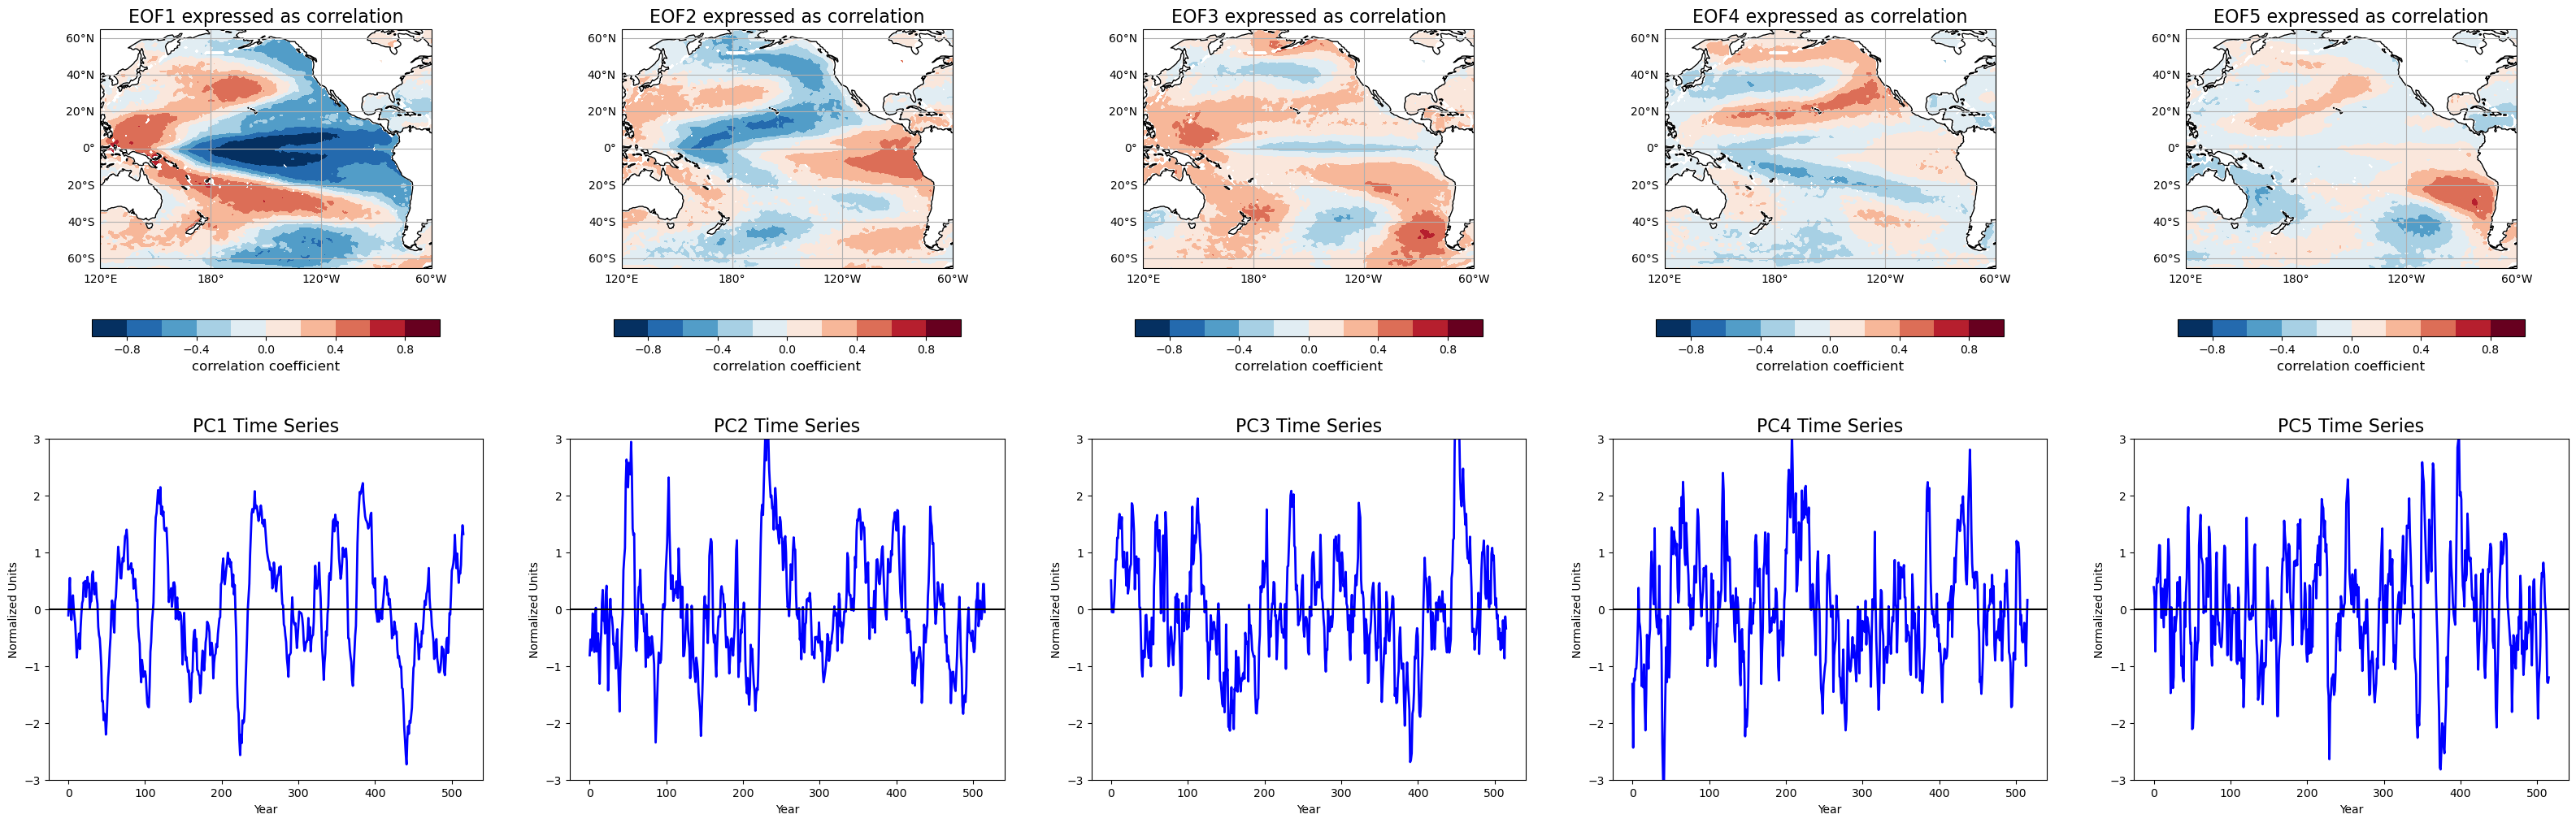

In [33]:
fig = plt.figure(figsize=(40, 12))

n = 5
for i in range(n):
    # plot EOF as correlation
    ax = plt.subplot(2, n, i+1, projection=ccrs.PlateCarree(central_longitude=190))
    clevs = np.linspace(-1, 1, 11)
    fill = eof1[i].plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                                 add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
    cb = plt.colorbar(fill, ax=ax, orientation='horizontal', shrink=0.8)
    gl = ax.gridlines(draw_labels=True)
    gl.right_labels = False
    gl.top_labels = False
    cb.set_label('correlation coefficient', fontsize=12)
    ax.set_title('EOF{} expressed as correlation'.format(i+1), fontsize=16)

    # plot PC time series
    ax = plt.subplot(2, n, i+1+n)
    ax.plot(pc1[:, i], color='b', linewidth=2)
    ax.axhline(0, color='k')
    ax.set_ylim(-3, 3)
    ax.set_xlabel('Year')
    ax.set_ylabel('Normalized Units')
    ax.set_title('PC{} Time Series'.format(i+1), fontsize=16)
        

# §4 Variance Fraction

In [34]:
varfrac = solver.varianceFraction()

(5.164758216991563e-34, 0.1933732190221443)

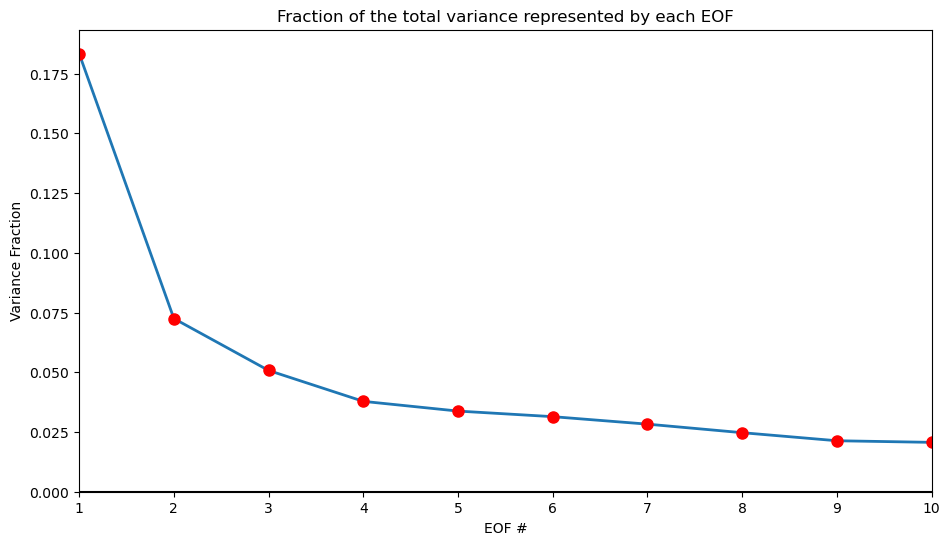

In [35]:
# Plot the fraction of variance explained by each EOF
n = 10

plt.figure(figsize=(11,6))
eof_num = range(1, n+1)
plt.plot(eof_num, varfrac[0:n], linewidth=2)
plt.plot(eof_num, varfrac[0:n], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, n)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)

# §5 Reconstruction and Correlation with Observation

/opt/anaconda3/envs/default/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/default/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0.5, 1.0, 'Correlation between Reconstructed and Observed SST Anomalies')

/opt/anaconda3/envs/default/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


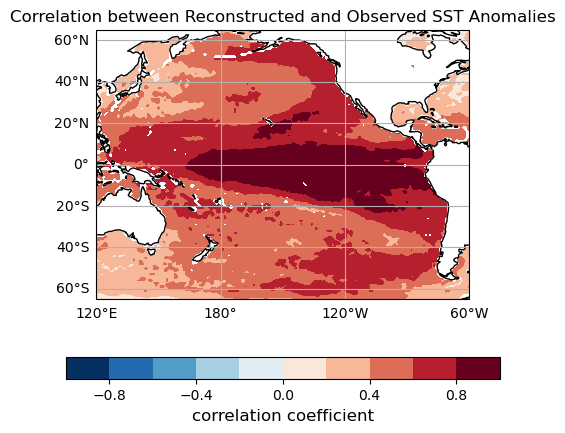

In [39]:
reconstruction = solver.reconstructedField(neofs=5)

corr = xr.corr(reconstruction, sstk_standard, dim='time')

fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=190))
clevs = np.linspace(-1, 1, 11)
fill = corr.plot.contourf(ax=ax, levels=clevs, cmap=plt.cm.RdBu_r,
                             add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, ax=ax, orientation='horizontal', shrink=0.7)
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('Correlation between Reconstructed and Observed SST Anomalies', fontsize=12)


# §6 Correlation between SST EOF1 and Precipitation

## §6.1 Processing Precipitation data

In [40]:
# extract from dataset
tp_anom = ds_anomaly['TP_anom'].isel(latitude=slice(None,None,4), longitude=slice(None,None,4))


In [43]:
# deseasoning
tp_deseason = tp_anom.groupby('time.month') - tp_anom.groupby('time.month').mean(dim='time')
tp_deseason = tp_deseason.drop('month')

# detrending
tp_detrend = detrend_dim(tp_deseason, 'time', 1)

# standardizing
climatology_mean = tp_detrend.groupby('time.month').mean('time')
climatology_std = tp_detrend.groupby('time.month').std('time')
tp_standard = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    tp_detrend.groupby('time.month'),
    climatology_mean, climatology_std,
    dask = 'parallelized'
)
tp_standard = tp_standard.drop('month')
tp_standard

/opt/anaconda3/envs/default/lib/python3.9/site-packages/xarray/core/indexing.py:1374: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


<xarray.DataArray (time: 516, latitude: 131, longitude: 181)>
dask.array<getitem, shape=(516, 131, 181), dtype=float64, chunksize=(1, 131, 181), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01

In [47]:
%%time
tp_standard = tp_standard.compute()

CPU times: user 3.8 s, sys: 799 ms, total: 4.6 s
Wall time: 10.6 s


## §6.2 Correlation and Plot

In [48]:
corr2 = xr.corr(eof1[0], tp_standard, dim='time')

/opt/anaconda3/envs/default/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/anaconda3/envs/default/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [49]:
corr2

<xarray.DataArray (latitude: 131, longitude: 181)>
array([[            nan,             nan,             nan, ...,
         1.43689128e-17, -2.99807062e-17, -1.87775564e-17],
       [            nan,             nan,             nan, ...,
        -1.10161664e-17, -3.12959274e-18,  2.36847579e-17],
       [            nan,             nan,             nan, ...,
         7.65011559e-18,  4.01631068e-18, -1.67048426e-17],
       ...,
       [-1.42450428e-18, -1.54914841e-17, -1.47198776e-17, ...,
                    nan,             nan,             nan],
       [ 6.31134536e-18, -3.81328839e-18,  1.50611651e-17, ...,
                    nan,             nan,             nan],
       [-2.49843212e-17, -1.42343724e-17,  8.60638004e-18, ...,
                    nan,             nan,             nan]])
Coordinates:
    mode       int64 0
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0

Text(0.5, 1.0, 'Correlation between SST Anomalies EOF1 and Precipitation Anomalies')

/opt/anaconda3/envs/default/lib/python3.9/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


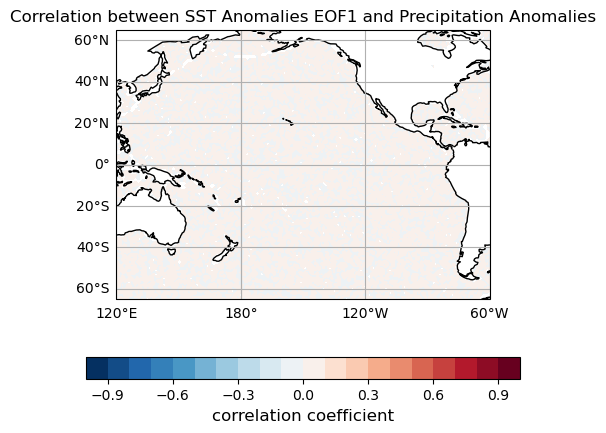

In [54]:
fig = plt.figure(figsize=(8,5))
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=190))
clevs = np.linspace(-1, 1, 21)
fill = corr2.plot.contourf(
    ax=ax, cmap=plt.cm.RdBu_r,
    levels=clevs, 
    add_colorbar=False, 
    transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
cb = plt.colorbar(fill, ax=ax, orientation='horizontal', shrink=0.7)
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
gl.top_labels = False
cb.set_label('correlation coefficient', fontsize=12)
ax.set_title('Correlation between SST Anomalies EOF1 and Precipitation Anomalies', fontsize=12)